## 1. Parallel and Distributed Optimization

This notebook provides concise BlueFog demos to concepts or algorithms introduced in the tutorial. 


### 1.1 Finite-sum optimizaiton example: distributed least square

Suppose $m$ computing nodes collaborate to solve the following problem:

\begin{align*}
\min_{x\in \mathbb{R}^d}\ \sum_{i=1}^n h_i(x) \quad \mbox{where} \quad h_i(x) = \frac{1}{2}\|A_i x - b_i\|^2 \hspace{1cm} \mbox{(Opt-Problem)}
\end{align*}

where $h_i(x): \mathbb{R}^d \to \mathbb{R}$ is a local cost function held by node $i$ and $\{A_i, b_i\}$ are local data. Each node $i$ can evaluate its own data and gradient, but it has to communicate to achieve information from the other node. We let $x^\star$ denote the global solution to the above problem

### 1.2 All-reduce

BlueFog supports the Ring-Allreduce operation as follows: 
```
x_bar = bf.allreduce(x_local)
```

In the following code, we activate 8 computing nodes (CPUs) and label them as $0,1,\cdots,7$. We target to let all nodes collaborate to compute the global average of their labels $(\sum_{i=0}^7 i)/8 = 3.5$.

In [1]:
%%writefile Allreduce.py
 
import bluefog.torch as bf
import torch

bf.init()
x_local = torch.ones(1) * bf.rank()
x_bar = bf.allreduce(x_local)
print('Node {} achieved the global average {}'.format(bf.rank(), x_bar[0]))

Overwriting Allreduce.py


In [2]:
! bfrun -np 8 python Allreduce.py

Node 0 achieved the global average 3.5
Node 6 achieved the global average 3.5
Node 5 achieved the global average 3.5
Node 3 achieved the global average 3.5
Node 2 achieved the global average 3.5
Node 4 achieved the global average 3.5
Node 7 achieved the global average 3.5
Node 1 achieved the global average 3.5


### 1.3 Distributed Gradient Descent

The distributed gradient descent is $x^{k+1} = x^k - \frac{\alpha}{n}\sum_{i=1}^n \nabla h_i(x^k)$. This process can be implemented as

```python
# core distributed gradient descent snippet 
grad = A.T.mm(A.mm(x) - b)
next_x = x - alpha * bf.allreduce(grad)
```

In [3]:
%%writefile DistributedGD.py
 
import bluefog.torch as bf
import torch

bf.init()
# Make sure different agent has different random seed.
torch.manual_seed(12345 * bf.rank())

def generate_data(m, d):
    A = torch.randn(m, d).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    x_o = torch.rand(d,1).to(torch.double)
    b = A.mm(x_o) + ns
    
    return A, b

def check_opt_cond(x, A, b):
    
    grad_local = A.t().mm(A.mm(x) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient
    
    # the norm of global gradient is expected to be 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))
        
    return
    

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    m, d = A.shape
    
    x_opt = torch.zeros(d, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    check_opt_cond(x_opt, A, b)
    
    return x_opt

if __name__ == "__main__":
    m, d = 20, 5 # dimension of A
    A, b = generate_data(m, d)
    x_opt = distributed_grad_descent(A, b, maxite=200, alpha=1e-2)

Overwriting DistributedGD.py


If $x^k\to x^\star$, it holds that $\sum_{i=1}^m \nabla h_i(x^k) \to 0$. We can use $\|\sum_{i=1}^m \nabla h_i(x)\|$ as a metric to gauge whether distributed gradient descent converge or not.

In [4]:
! bfrun -np 8 python DistributedGD.py

[Distributed Grad Descent] Rank 2: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 6: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 0: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 1: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 4: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 7: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 5: global gradient norm: 8.052753044735446e-15
[Distributed Grad Descent] Rank 3: global gradient norm: 8.052753044735446e-15


### 1.4 Primal Decomposition

We consider the following linearly-constrained resource sharing problem:

\begin{align*}
\min_{\{x_i\}, y}&\quad \|y\|_1 + \frac{1}{2}\sum_{i=1}^n \|A_i x_i - b_i\|^2 \\
\mathrm{s.t.} &\quad\sum_{i=1}^n B_i x_i = y
\end{align*}

where $x_i \in \mathbb{R}^d$, $A_i \in \mathbb{R}^{m\times d}$, and $B_i \in \mathbb{R}^{d\times d}$. For simplicity, we assume each $B_i$ is a invertible matrix. Each node $i$ has local data $\{A_i, B_i, b_i\}$. To solve the above problem in a distributed manner, we introduce $y_i = B_i x_i$ so that $y=\sum_{i=1}^n y_i$. Since $B_i$ is invertible, we have $x_i = B_i^{-1} y_i$. Substituting these facts into the above problem, we achieve

\begin{align*}
\min_{\{y_i\}}&\quad \|y_1 + \cdots + y_n\|_1 + \frac{1}{2}\sum_{i=1}^n \|A_i B_i^{-1} y_i - b_i\|^2 
\end{align*}

which can be solved in the following distributed manner. For notation simplicity, we let $C_i = A_i B_i^{-1}$ and $g(y_1,\cdots, y_n) = \|y_1 + \cdots + y_n\|_1$. Following proximal gradient descent, we have 

\begin{align*}
z_i^{k+1} &= y_i^k - \alpha C_i^T(C_i y_i^k - b_i), \quad \forall\ i=1,\cdots, n\\
y_i^{k+1} &= [\mathrm{Prox}_{\alpha g}(z_1^{k+1},\cdots, z_n^{k+1})]_{i} =z_i^{k+1} - \alpha v^{k+1}, \quad \forall\ i=1,\cdots, n \\
x_i^{k+1} &= B_i^{-1} y_i^{k+1}, \quad \forall\ i=1,\cdots, n
\end{align*}

where 
$$v^{k+1} = \frac{1}{n\alpha^2}\big(\alpha(z^{k+1}_1 + \cdots + z^{k+1}_n) - \mathrm{Prox}_{n \alpha^2 \|\cdot\|_1}(\alpha z^{k+1}_1 + \cdots + \alpha z^{k+1}_n)\big) \quad \mbox{(Need Allreduce Communication)}$$

In [5]:
%%writefile PrimalDecompose.py
 
import bluefog.torch as bf
import torch

bf.init()
# Make sure different agent has different random seed.
torch.manual_seed(12345 * bf.rank())

def generate_data(m, d):
    A = torch.randn(m, d).to(torch.double)
    B_inv = torch.randn(d, d).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    x_o = torch.rand(d,1).to(torch.double)
    b = A.mm(x_o) + ns
    
    return A, B_inv, b

def soft_threshold(x, kappa):
    
    zeros = torch.zeros(d,1).to(torch.double)
    x = torch.max(x - kappa, zeros)
    x = torch.min(x + kappa, zeros)
    
    return x

def check_opt_cond(y, A, B_inv, b, alpha):
    
    m, d = A.shape
    n = bf.size()
    C = A.mm(B_inv)
    
    # update z
    grad_local = C.t().mm(C.mm(y) - b)
    z = y - alpha*grad_local
    z_bar = bf.allreduce(z)
    z_sum = z_bar * n

    # update v
    v = (1/(n*alpha*alpha)) * (alpha*z_sum - soft_threshold(alpha*z_sum, n*alpha*alpha))

    # update y
    y_next = z - alpha*v
    
    # the norm of global gradient is expected to be 0 (optimality condition)
    global_grad_norm = torch.norm((y - y_next), p=2)
    print("[Primal Decomposition] Rank {}: optimality metric norm: {}".format(bf.rank(), global_grad_norm))
        
    return

def primal_decomposition(A, B_inv, b, maxite=5000, alpha=1e-1):

    m, d = A.shape
    n = bf.size()
    C = A.mm(B_inv)
    
    y = torch.zeros(d, 1, dtype=torch.double)

    for _ in range(maxite):
        # update z
        grad_local = C.t().mm(C.mm(y) - b)
        z = y - alpha*grad_local
        z_bar = bf.allreduce(z)
        z_sum = z_bar * n
        
        # update v
        v = (1/(n*alpha*alpha)) * (alpha*z_sum - soft_threshold(alpha*z_sum, n*alpha*alpha))
        
        # update y
        y = z - alpha*v

        # update x
        x = B_inv.mm(y)

    check_opt_cond(y, A, B_inv, b, alpha)
    
    return y

if __name__ == "__main__":
    m, d = 20, 5 # dimension of A
    A, B_inv, b = generate_data(m, d)
    y = primal_decomposition(A, B_inv, b, maxite=5000, alpha=3e-3)

Overwriting PrimalDecompose.py


We define $G^k_i = \frac{1}{\alpha}\big(y_i^k - [\mathrm{Prox}_{\alpha g}(z_1^{k+1},\cdots, z_n^{k+1})]_i\big)$ and use $\|G^k_i\|$ as the metric to evaluate the optimality of $y_i^k$.

In [6]:
! bfrun -np 4 python PrimalDecompose.py

[Primal Decomposition] Rank 3: optimality metric norm: 0.00010111695583254255
[Primal Decomposition] Rank 7: optimality metric norm: 4.335475665097798e-06
[Primal Decomposition] Rank 4: optimality metric norm: 1.2605012098919914e-05
[Primal Decomposition] Rank 5: optimality metric norm: 2.662265782459985e-06
[Primal Decomposition] Rank 2: optimality metric norm: 1.526888906509641e-05
[Primal Decomposition] Rank 0: optimality metric norm: 6.132838767022468e-05
[Primal Decomposition] Rank 1: optimality metric norm: 0.0001353219355041033
[Primal Decomposition] Rank 6: optimality metric norm: 3.114355867260097e-05


### 1.5 Distributed ADMM

Suppose we want to optimize the following consensus problem:
$$
    \min_{x} \sum_{i=1}^n f_i(x)
$$
Each machine $i$ can access the function $f_i$ only. Note the problem has a shared $x$ cross all machines. To relax this condition, we can reformat the problem into the following equivalent form:
\begin{align}
    \min_{\{x_i\}, y} & \;\;\; \sum_{i=1}^n f_i(x_i),\\
    {\rm subject\ to} & \;\;\;  x_i = y,\;\; \forall i. 
\end{align}

Applying ADMM, we obtain:

\begin{align}
    x^{k+1}_i =&\;\; {\rm argmin}_{x_{i}} \left\{ f_i(x_i) + \langle u_i^k, x_i - y^k\rangle + \frac{\alpha}{2}  \left\|x_i - y^k \right\|^2\right\} \\
    y^{k+1} =&\;\; \frac{1}{n} \left(x_i^{k+1} + \frac{1}{\alpha} u^k_i\right)\\
    u^{k+1}_i = &\;\; u^k_i + \alpha\left(x_i^{k+1} - y^{k+1} \right)
\end{align}


We can further simplify it by noticing that $u^k_1,\ldots,u^k_n$ has mean 0. Here we provide the code snippet of a simple quadratic cost function again. 

``` python
# For each agent, it owns data A and b differently. 
def CentralizedADMMStepL2(A, b, x, y, u, alpha):
    next_x = ProximalStepL2(A, b, x, y, u, alpha)
    # We use allreduce to mimic the centralized behavior
    # It should be based on PS architecture and using gather and broadcast.
    next_y = bf.allreduce(next_x)   # Without u is okay since allreudce(u) == 0
    next_u = u + alpha * (next_x - next_y)
    return next_x, next_y, next_u
```

In [7]:
# ! bfrun -np 8 python CentralizedADMM.py

[Centralized ADMM] Rank 3: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 2: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 7: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 5: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 1: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 6: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 0: ADMM residue gradient norm: 5.437249906887428e-15
[Centralized ADMM] Rank 4: ADMM residue gradient norm: 5.437249906887428e-15
Last three entries of x_ar:
 tensor([[0.4883],
        [0.6776],
        [0.6447]], dtype=torch.float64)
Last three entries of x_admm:
 tensor([[0.4883],
        [0.6776],
        [0.6447]], dtype=torch.float64)


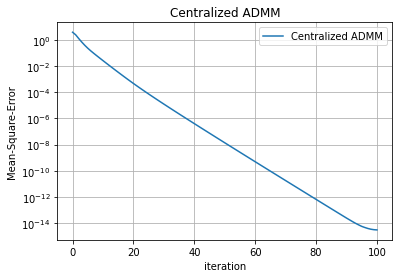

In [8]:
import matplotlib.pyplot as plt
import scipy.io as sio
import os
%matplotlib inline
mse_records_dict = sio.loadmat('results/CentralizedADMM.mat')

plt.semilogy(mse_records_dict["mse"][0], label="Centralized ADMM")
plt.title("Centralized ADMM")
plt.xlabel("iteration")
plt.ylabel("Mean-Square-Error")
plt.grid("on")
plt.legend()
dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'centralized_admm.png'))



You can find the full code in the `CentralizedADMM.py`

**Exercise**: Modify the loss function, (sub-)gradient, and proximal step for $\ell_1 + \ell_2$ cases.